In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [ ]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *


In [ ]:
path=untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/images')]

In [ ]:
path_lbl=path/'labels'
path_img=path/'images'

In [ ]:
fnames=get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00000.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_007050.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_04920.png')]

In [ ]:
lbl_names=get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_00600_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_01260_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08139_P.png')]

In [ ]:
img_f=fnames[0]
img=open_image(img_f)

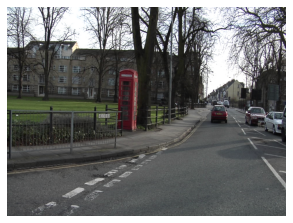

In [ ]:
img.show(figsize=(5,5))

In [ ]:
get_y_fn=lambda x:path_lbl/f'{x.stem}_P{x.suffix}'


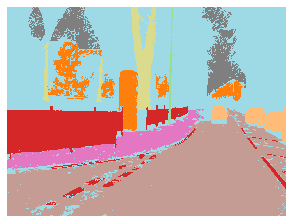

In [ ]:
mask=open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5),alpha=1)

In [ ]:
src_size=np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[30, 30, 30,  ..., 29, 29, 29],
          [30, 30, 30,  ..., 29, 29, 29],
          [30, 30, 30,  ..., 29, 29, 29],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [ ]:
codes=np.loadtxt(path/'codes.txt',dtype=str);
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [ ]:
size=src_size//2
free=gpu_mem_get_free_no_cache()
if free>8200:bs=8
else:        bs=4
print(f"using bs={bs},have {free}MB of GPU RAM free")

using bs=8,have 15068MB of GPU RAM free


In [ ]:
src=(SegmentationItemList.from_folder(path_img)
     .split_by_fname_file('../valid.txt')
     .label_from_func(get_y_fn,classes=codes))

In [ ]:
data=(src.transform(get_transforms(),size=size,tfm_y=True)
      .databunch(bs=bs)
      .normalize(imagenet_stats))

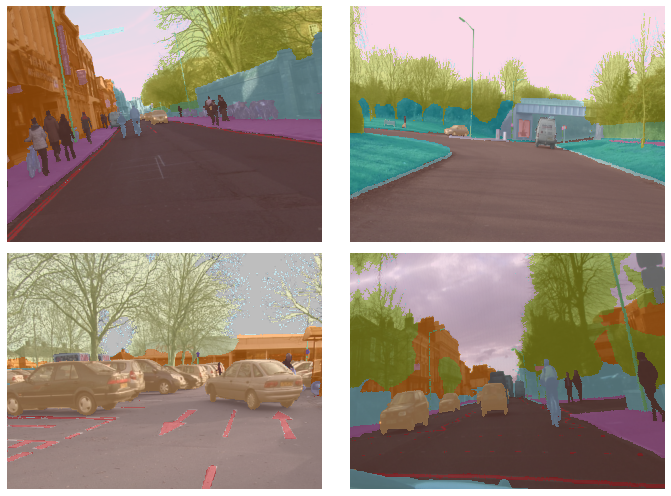

In [ ]:
data.show_batch(2,figsize=(10,7))

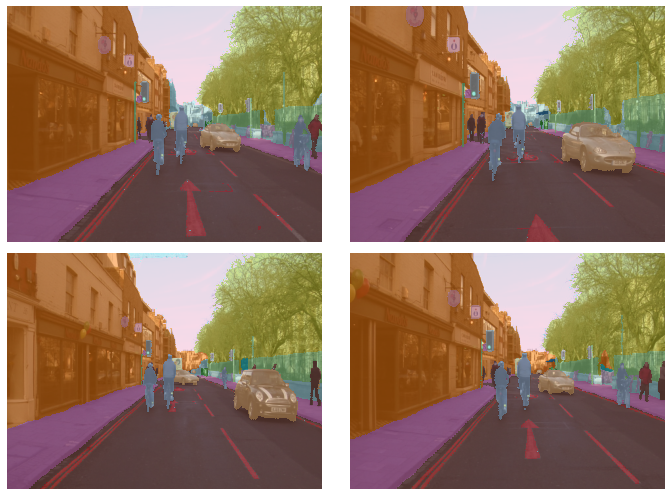

In [ ]:
data.show_batch(2,figsize=(10,7),ds_type=DatasetType.Valid)

In [ ]:
name2id={v:k for k,v in enumerate(codes)}
void_code=name2id['Void']
def acc_camvid(input,target):
  target=target.squeeze(1)
  mask=target !=void_code
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_camvid

In [ ]:
wd=1e-2

In [ ]:
learn=unet_learner(data,models.resnet34,metrics=metrics,wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


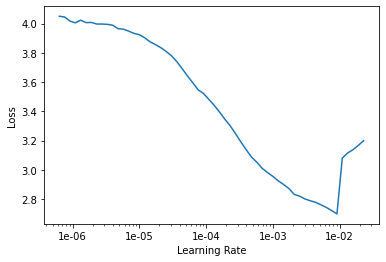

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=3e-3


In [ ]:
learn.fit_one_cycle(10,slice(lr),pct_start=0.9)


epoch,train_loss,valid_loss,acc_camvid,time
0,1.266518,0.791390,0.816857,01:26
1,0.855741,0.610225,0.838769,01:23
2,0.726526,0.566332,0.845655,01:23
3,0.627905,0.542717,0.855193,01:23
4,0.631253,0.574473,0.862620,01:22
5,0.840309,0.722521,0.814967,01:22
6,0.668772,0.595793,0.849914,01:21
7,0.559377,0.450881,0.871402,01:21
8,0.538226,0.411297,0.889508,01:21
9,0.478846,0.362452,0.898311,01:21


In [ ]:
learn.save('stage-1')
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

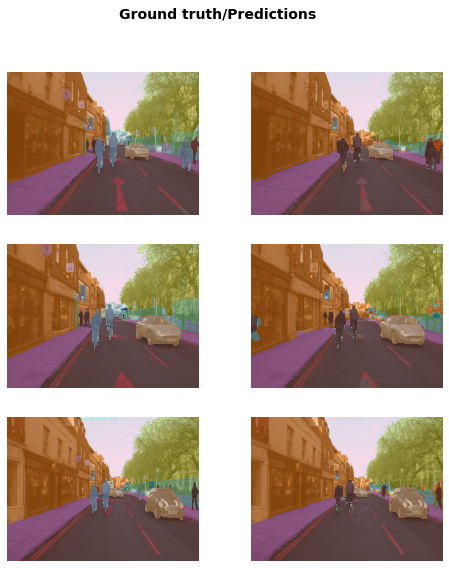

In [ ]:
learn.show_results(rows=3,figsize=(8,9))

In [ ]:
learn.unfreeze()

In [ ]:
lrs=slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12,lrs,pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.406033,0.343075,0.902026,01:24
1,0.391832,0.326598,0.907656,01:24
2,0.386137,0.321656,0.906885,01:24
3,0.368024,0.325419,0.912668,01:24
4,0.357019,0.298564,0.916154,01:24
5,0.353990,0.320236,0.912886,01:24
6,0.342876,0.291851,0.919970,01:24
7,0.342710,0.358993,0.900126,01:24
8,0.328107,0.313568,0.917557,01:24
9,0.309530,0.299087,0.916457,01:24


In [ ]:
learn.save('stage-2')

In [ ]:
learn.destroy()
size=src_size
free=gpu_mem_get_free_no_cache()
if free>8200:bs=3
else:        bs=1
print(f"using bs={bs},have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3,have 14275MB of GPU RAM free


In [ ]:
data=(src.transform(get_transforms(),size=size,tfm_y=True)
      .databunch(bs=bs)
      .normalize(imagenet_stats))

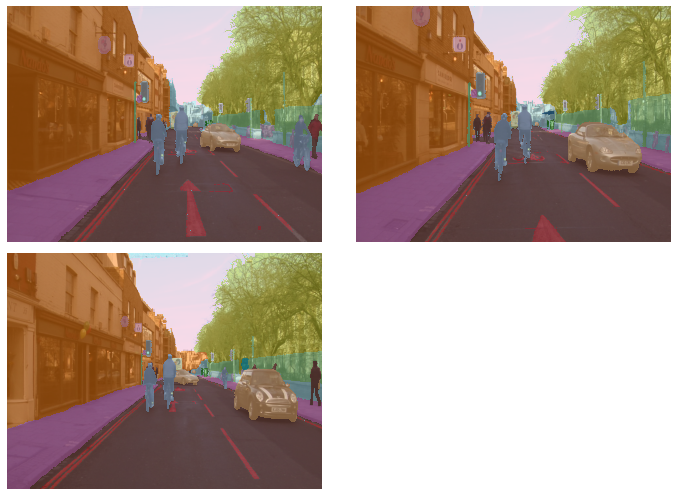

In [ ]:
data.show_batch(2,figsize=(10,7),ds_type=DatasetType.Valid)